In [0]:
import os
os.chdir('./drive/My Drive/Challenge-Owkin/')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Metrics

In [0]:
import numpy as np
import pandas as pd
import warnings


def cindex(y_true_times, predicted_times, tol=1e-8):
    """
    Author: Romuald Menuet & Rémy Dubois

    Evaluate concordance index from Pandas DataFrame, taking ties into account.

    Args:
        y_true_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `Event` and `SurvivalTime` the float-valued column of true survival times.
        predicted_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `SurvivalTime` the float-valued column of predicted survival times,
            and one `Event`column, whose value does not matter. It must be appended so that target and predictions have the same format.
        tol: float
            small float value for numerical stability.
    Returns:
        Concordance index, as described here:
        https://square.github.io/pysurvival/metrics/c_index.html
    """

    assert isinstance(y_true_times, pd.DataFrame), 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert isinstance(predicted_times, pd.DataFrame), 'Predicted times should be pd dataframe with patient `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(y_true_times.shape) == 2, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(predicted_times.shape) == 2, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(y_true_times.columns) == {'Event', 'SurvivalTime'}, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(predicted_times.columns) == {'Event', 'SurvivalTime'}, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    np.testing.assert_equal(y_true_times.shape, predicted_times.shape, err_msg="Not same amount of predicted versus true samples")
    assert set(y_true_times.index) == set(predicted_times.index), 'Not same patients in prediction versus ground truth'
    assert np.all(predicted_times['SurvivalTime'] > 0), 'Predicted times should all be positive'

    events = y_true_times.Event
    y_true_times = y_true_times.SurvivalTime
    predicted_times = predicted_times.SurvivalTime

    # Just ordering the right way
    predicted_times = predicted_times.loc[y_true_times.index]
    events = events.loc[y_true_times.index]

    events = events.values.astype(int)
    y_true_times = y_true_times.values.astype(float)
    predicted_times = predicted_times.values.astype(float)
    # events = events.values.astype(bool)

    np.testing.assert_array_less(1.,
                                 predicted_times.astype(float),
                                 err_msg="Predicted y_true_times all below 1.\
                                 It should be in days. Make sure that you are not predicting risk instead of time.")

    return _cindex_np(y_true_times, predicted_times, events)


def _cindex_np(times, predicted_times, events, tol=1.e-8):
    """
    Raw CI computation from np arrray. Should not be used as is.
    """
    assert times.ndim == predicted_times.ndim == events.ndim == 1, "wrong input, should be vectors only"
    assert times.shape[0] == predicted_times.shape[0] == events.shape[0], "wrong input, should be vectors of the same len"

    risks = - predicted_times

    risks_i = risks.reshape((-1, 1))
    risks_j = risks.reshape((1, -1))
    times_i = times.reshape((-1, 1))
    times_j = times.reshape((1, -1))
    events_i = events.reshape((-1, 1))

    eligible_pairs = (times_i < times_j) * events_i

    well_ordered = np.sum(eligible_pairs * (risks_i > risks_j))
    ties = + np.sum(eligible_pairs * 0.5 * (risks_i == risks_j))

    return (well_ordered + ties) / (eligible_pairs.sum() + tol)


# Read files

In [0]:
from sklearn import preprocessing

def normalizing_input(x_train, x_test):
    all_x = pd.concat([x_train, x_test])
    x_val = all_x.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_val)
    df = pd.DataFrame(x_scaled, index=all_x.index, columns=all_x.columns)
    return df.loc[x_train.index], df.loc[x_test.index]

def cleaning_clinical(clinical):
    """
    Cleaning the clinical dataframe.
    :param clinical:
    :return:
    """
    # Encoding label for SourceDataset
    le = preprocessing.LabelEncoder()
    le.fit(clinical['SourceDataset'])
    le.transform(clinical['SourceDataset'])
    clinical['SourceDataset'] = le.transform(clinical['SourceDataset'])
    # Cleaning Histology
    clinical.replace("NSCLC NOS (not otherwise specified)", "nos", inplace=True)
    clinical.replace("Adenocarcinoma", "adenocarcinoma", inplace=True)
    clinical.replace("Squamous cell carcinoma", "squamous cell carcinoma", inplace=True)
    # Dummies for Histology
    clinical = pd.get_dummies(clinical)
    # Fill age nan
    clinical['age'].fillna((clinical['age'].mean()), inplace=True)

    return clinical

def clean_clinical_data(file, newfile):
    """
    Cleaning clinical data.
    :param file: clinical data file
    :param newfile: path for the cleaned data file.
    :return:
    """
    clinical = pd.read_csv(file, index_col=0)
    cleaned = cleaning_clinical(clinical)
    cleaned.to_csv(newfile)

def y_dataframe_to_rsf_input(y_df):
    """
    Input for random survival forest.
    :param y_df: event + survival time dataframe.
    :return:
    """
    y_array = []
    Y = y_df.to_numpy()
    for y in Y:
        tuple = (bool(y[1]), y[0])
        y_array.append(tuple)
    return np.array(y_array, dtype = [(f'{y_df.columns[1]}', np.bool), (f'{y_df.columns[0]}', np.float)])

In [0]:
def read_input(file_radiomics, file_clinical):
    """
    Read radiomics and clinical feature and return dataframe.
    :param file_radiomics: filename
    :param file_clinical: filename
    :return:
    """
    radiomics = pd.read_csv(file_radiomics, index_col=0)
    clinical = pd.read_csv(file_clinical, index_col=0)
    clinical = cleaning_clinical(clinical)
    input = pd.concat([radiomics, clinical], axis=1)
    return input

def read_output(file_output):
    """
    Return dataframe for event + survival time.
    :param file_output:
    :return:
    """
    output = pd.read_csv(file_output, index_col=0, header=0)
    return output

def load_owkin_data(radiomics_path_train="data/train/features/radiomics.csv",
                    clinical_path_train="data/train/features/clinical_data.csv",
                    label_path_train='data/train/y_train.csv',
                    radiomics_path_test="data/test/features/radiomics.csv",
                    clinical_path_test="data/test/features/clinical_data.csv"):
    """
    Load Owkin data: return PyRadiomics + clinical features of training set in dataframe,
                    event + time of training set in dataframe, and
                    PyRadiomics + clinical features of testing set in dataframe,
    """
    input_train = read_input(radiomics_path_train, clinical_path_train)
    output_train = read_output(label_path_train)
    input_test = read_input(radiomics_path_test, clinical_path_test)
    return input_train, output_train, input_test


input_train, output_train, input_test = load_owkin_data()
all_features = input_train.columns

# Data exploration

## Global distribution

In [0]:
x_train, y_train, x_test = load_owkin_data()
x_train

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,1.592466,241.0,-310.858031,288.311105,-266.0,-1006.0,1247.0,446.407319,-0.281714,320.385361,0.037008,102646.779451,1056.843506,546253.499762,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761,0,0,1,2,66.000000,1,0,0,0
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,3.371013,262.0,-134.429809,191.395154,-15.0,-945.0,1207.0,268.966000,-1.216062,232.962090,0.080061,54271.335557,1219.689108,331155.230396,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589,0,2,0,4,64.572200,0,1,0,0
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,7.585494,115.0,-54.136093,94.132136,2.0,-785.0,900.0,141.852795,-2.153344,131.116356,0.160905,17191.498865,972.465798,54523.086867,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,0,3,0,2,66.045200,0,0,0,1
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,4.281865,274.0,-118.705522,149.072998,-37.0,-850.0,1124.0,224.397694,-1.437836,190.429315,0.074476,36263.324022,968.117567,166735.779994,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,0,2,0,3,59.356600,0,0,1,0
284,0.0236

## Low and high survival probability population

En regardant le temps de survie dans patients labelisé Event = 0 ou Event = 1, j'ai splitté deux groupes de populations, une qui a une très faible chance de survie, et une autre avec une grand chance de survie, pour voir si ces deux groupes avaient des valeurs de features caractéristiques. Résultat: y'a juste deux features très discriminants, SourceDataset (ce qui est assez vache) et Histology_adenocarcinoma, et quelques autres qui discriminent un peu (les valeurs moyennes sont assez proches, mais la dispersion est encore petite pour pouvoir dire qu'on a deux groupes différents). Pour les autres, soit la dispersion est trop grande donc on peut rien dire, soit au contraire ces features se concentrent autour de la même valeur pour les deux populations, donc ça permet pas de différencier les populations. Le dataset en soi est donc assez difficile. Je pense que dans un premier temps faut tèje les variables inutiles (trop dispersées ou non informatives), ça sera la partie feature sélection, et après l'idéal c'est de construire des nouveaux features discriminants à partir du set restreint de features PyRadiomics / clinique, et images.

In [0]:
x_train, y_train, x_test = load_owkin_data()
x_train, x_test = normalizing_input(x_train, x_test)

162 138


Text(0.5, 1.0, 'Histogram distribution according to event')

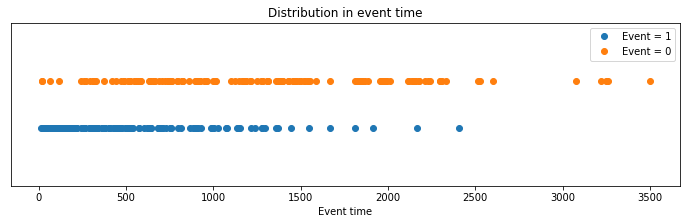

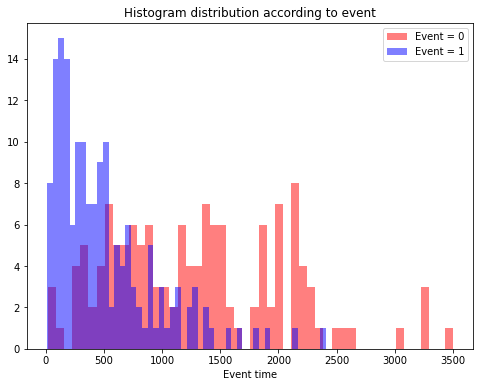

In [0]:
""" Distribution of patient in event time """
dead = y_train.loc[y_train['Event'] == 1]['SurvivalTime']
alive = y_train.loc[y_train['Event'] == 0]['SurvivalTime']
print(len(dead), len(alive))

plt.figure(figsize=(12, 3))
plt.plot(dead, np.zeros(len(dead)), 'o', label='Event = 1')
plt.plot(alive, np.zeros(len(alive)) + 0.4, 'o', label='Event = 0')
plt.ylim([-0.5, 0.9])
plt.xlabel('Event time')
plt.yticks([])
plt.legend()
plt.title('Distribution in event time')

plt.figure(figsize=(8,6))
n_bins = 50
plt.hist(alive, bins = n_bins, fc=(1, 0, 0, 0.5), label = 'Event = 0')
plt.hist(dead, bins = n_bins, fc=(0, 0, 1, 0.5), label = 'Event = 1')
plt.legend()
plt.xlabel('Event time')
plt.title('Histogram distribution according to event')


**Hypothesis**: Patients with event 1 (people who died in the experience) with an event time less than 300 are considered as low survival probability patients. Patients with event 0 (people who are still alive in the experience) with an event time higher than 2000 are considered as high survival probability patients.

In [0]:
""" Low survival probability patients """
dead_df = y_train.loc[y_train['Event'] == 1] 
low_survival_index = dead_df.loc[dead_df['SurvivalTime'] <= 500].index
low_surv_df = x_train.loc[low_survival_index]
print(f'Number of low survival probability patients: {len(low_survival_index)}')
print(low_survival_index)

""" High survival probability patients """
alive_df = y_train.loc[y_train['Event'] == 0]
high_survival_index = alive_df.loc[alive_df['SurvivalTime'] >= 1500].index
high_surv_df = x_train.loc[high_survival_index]
print(f'Number of high survival probability patients: {len(high_survival_index)}')
print(high_survival_index)

Number of low survival probability patients: 101
Int64Index([371, 384, 100, 173,  83, 423, 149, 316, 102, 249,
            ...
            112, 345, 299, 354, 373, 295, 213, 105,  56, 365],
           dtype='int64', name='PatientID', length=101)
Number of high survival probability patients: 49
Int64Index([284, 394, 178, 304, 421, 143, 180,  53,  94, 338, 380,  48, 334,
             39, 257, 331, 403, 388, 151, 308, 130,  91, 275, 115,  42, 406,
            305,  25, 184,  95, 131, 256, 148, 297, 393,  84,  36, 163, 391,
             11, 141, 279, 154, 362, 381,  69,  58, 261, 273],
           dtype='int64', name='PatientID')


In [0]:
""" Print features of the population having a small range Q3 - Q1 """
def small_range_Q3_Q1(df, threshold, title):
    descip = df.describe()
    range_df = descip.loc['75%'] - descip.loc['25%']

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].hist(range_df, 100)
    axs[0].set_xlabel('Value of the range Q3 - Q1')
    axs[0].set_title('Histogram of all the features according to their Q3 - Q1 range')
    small_range_id = range_df.loc[range_df < threshold]

    low_range_features = small_range_id.axes[0]
    df[low_range_features].boxplot(ax=axs[1], figsize=(8,6), rot=90)
    axs[1].set_title(f'Boxplot of the pop for only features with Q3 - Q1 < {threshold}')

    fig.suptitle(title)

    return small_range_id.axes[0]

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.476402,0.335141,0.321982,0.266604,0.529001,0.210168,0.272455,0.131952,0.061725,0.510419,0.118243,0.184491,0.775428,0.345475,0.858435,0.307685,0.249277,0.275224,0.611627,0.408463,0.294907,0.242956,0.605381,0.118148,0.387256,0.219607,0.084823,0.775846,0.396232,0.187427,0.166168,0.438821,0.581820,0.566204,0.485035,0.787726,0.870571,0.754060,0.598113,0.241447,0.686037,0.500815,0.589580,0.146258,0.105473,0.110472,0.530723,0.039752,0.569912,0.047246,0.509542,0.035881,0.205714,0.029703,0.321782,0.158416,0.344059,0.558008,0.227723,0.217822,0.178218,0.316832
std,0.173457,0.166450,0.195652,0.153115,0.172619,0.183855,0.211392,0.155133,0.085546,0.242460,0.181936,0.165187,0.172660,0.238864,0.161358,0.147532,0.156409,0.186487,0.170562,0.218355,0.212134,0.203402,0.219387,0.139078,0.100801,0.192068,0.111087,0.153960,0.204374,0.158845,0.151797,0.229303,0.236810,0.245050,0.158270,0.154150,0.166189,0.200761,0.207235,0.166099,0.197625,0.242696,0.225605,0.141577,0.156377,0.114490,0.245564,0.106124,0.215871,0.107909,0.181075,0.113548,0.162696,0.170613,0.300701,0.366952,0.257030,0.196801,0.421454,0.414824,0.384605,0.467562
min,0.045788,0.017690,0.023903,0.057762,0.060644,0.003058,0.026136,0.000474,0.000357,0.071819,0.003333,0.029309,0.279380,0.016698,0.108265,0.174419,0.028302,0.028038,0.000000,0.042157,0.010855,0.007781,0.131618,0.000688,0.094170,0.006610,0.000359,0.203515,0.000000,0.000000,0.003165,0.016297,0.040142,0.032800,0.000000,0.000000,0.179424,0.142017,0.055881,0.004558,0.053378,0.000000,0.000000,0.002510,0.000213,0.000952,0.000000,0.000492,0.132005,0.000420,0.10

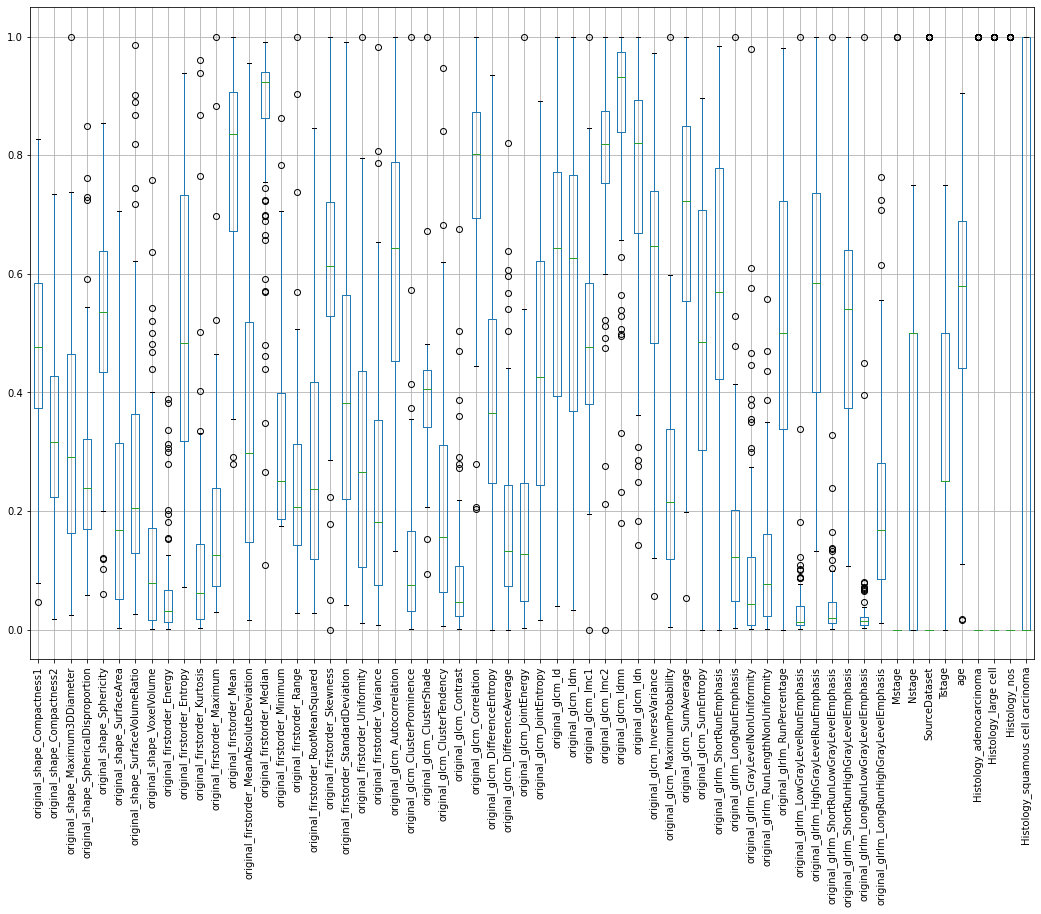

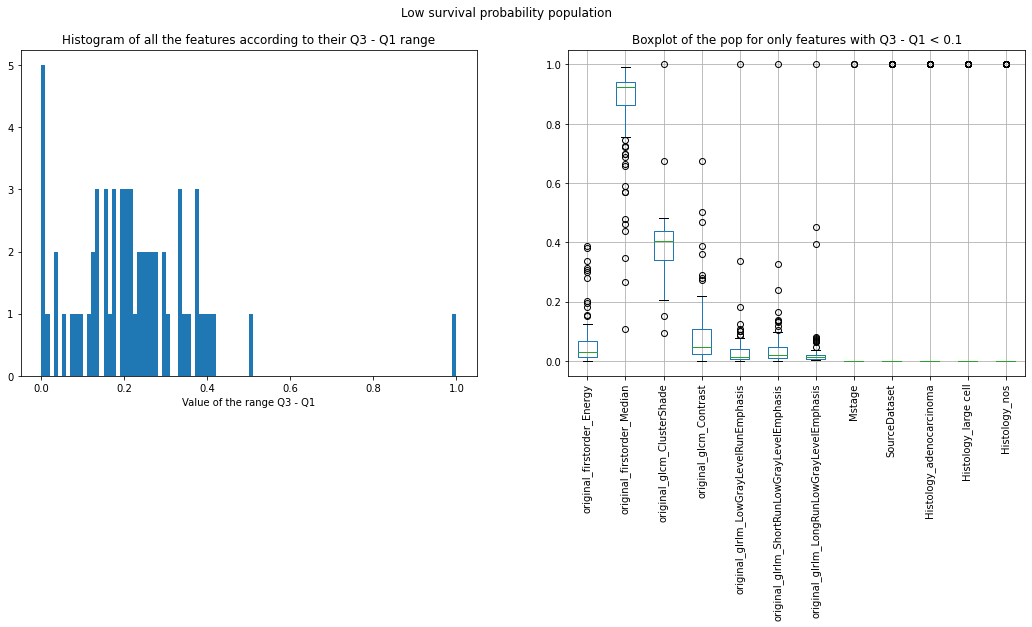

In [0]:
""" Statistics of the low survival probability population """
threshold = 0.1
low_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_low_surv = small_range_Q3_Q1(low_surv_df, threshold, 'Low survival probability population')
low_surv_df.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,0.528398,0.394370,0.154974,0.236880,0.577242,0.083413,0.497987,0.041246,0.051737,0.758203,0.023363,0.116175,0.531811,0.546354,0.624409,0.293413,0.191130,0.505160,0.744236,0.569388,0.101235,0.387421,0.403906,0.117521,0.414754,0.332789,0.251002,0.586743,0.678464,0.441507,0.047922,0.713074,0.246663,0.223391,0.659944,0.754262,0.610092,0.443823,0.305508,0.088494,0.495902,0.740208,0.863784,0.036450,0.027657,0.059445,0.841460,0.076636,0.374127,0.098085,0.397818,0.038744,0.066823,0.0,0.086735,0.836735,0.183673,0.519520,0.673469,0.020408,0.020408,0.244898
std,0.204048,0.207511,0.142206,0.166281,0.199582,0.170937,0.212652,0.113124,0.146943,0.190434,0.043704,0.096689,0.230091,0.198527,0.265962,0.124187,0.101149,0.223790,0.107704,0.179137,0.152075,0.195204,0.210356,0.087931,0.074341,0.180185,0.161003,0.190586,0.181871,0.195414,0.098254,0.203621,0.208747,0.211367,0.147428,0.130952,0.218249,0.214065,0.217157,0.126437,0.207686,0.201321,0.158136,0.080802,0.089419,0.175886,0.185898,0.103946,0.200209,0.116339,0.200210,0.086753,0.096787,0.0,0.201240,0.373438,0.259082,0.174567,0.473804,0.142857,0.142857,0.434483
min,0.070657,0.028427,0.002937,0.029617,0.092373,0.001760,0.053241,0.000431,0.000609,0.066163,0.002094,0.028990,0.010927,0.058309,0.000000,0.174419,0.075472,0.064524,0.355840,0.130948,0.004511,0.034069,0.072969,0.008526,0.277496,0.027396,0.007966,0.178999,0.090164,0.022466,0.000840,0.031450,0.021111,0.000551,0.145009,0.405984,0.000000,0.000000,0.014852,0.001273,0.111286,0.045437,0.170472,0.000000,0.000075,0.000847,0.068151,0.002905,0.087059,0.003963,0.102891,0.001823,0.006737,0.0,0.000000,0.000000,0.000000,0.070881,0.000000,0.000

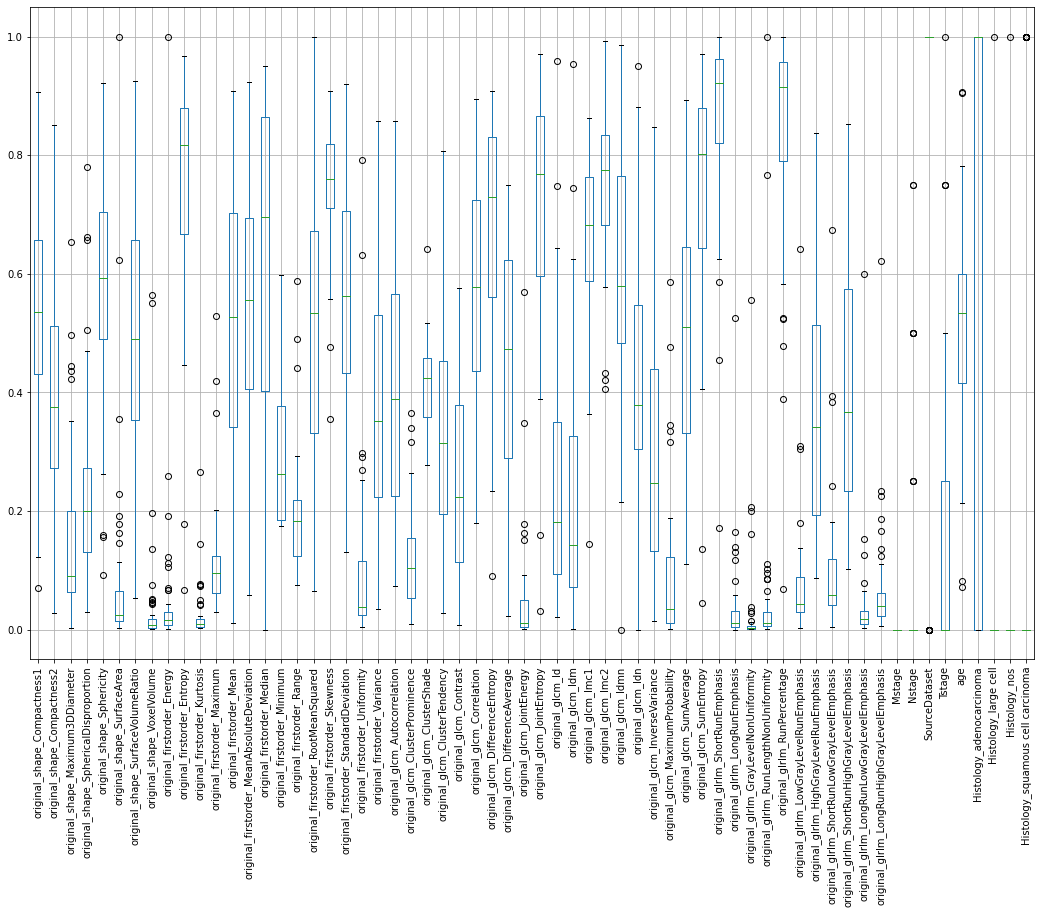

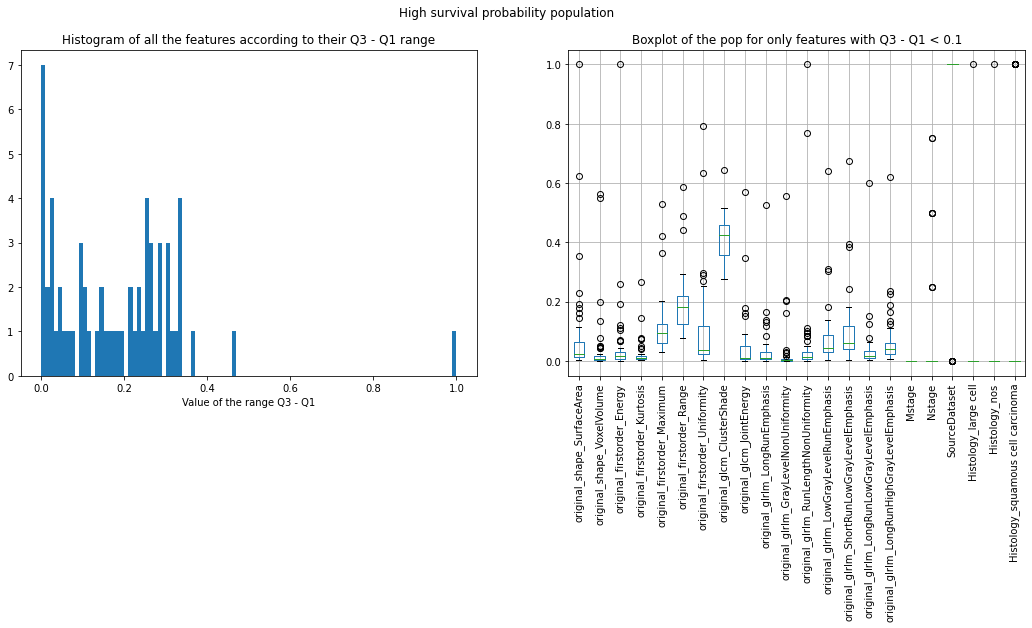

In [0]:
""" Statistics of the high survival probability population """
high_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_high_surv = small_range_Q3_Q1(high_surv_df, threshold, 'High survival probability population')
high_surv_df.describe()

In [0]:
""" Intersection of low quantile range features extracted from both population """
# print(low_range_features_low_surv)
# print(low_range_features_high_surv)
intersection_features = list(set(low_range_features_low_surv) & set(low_range_features_high_surv))
union_features = list(low_range_features_low_surv) + list(set(low_range_features_high_surv) - set(low_range_features_low_surv))
print('Features with low range in both population', intersection_features)
print('Features with low range in one of the population', union_features)

Features with low range in both population ['original_glcm_ClusterShade', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'SourceDataset', 'Mstage', 'original_firstorder_Energy', 'Histology_large cell', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'Histology_nos']
Features with low range in one of the population ['original_firstorder_Energy', 'original_firstorder_Median', 'original_glcm_ClusterShade', 'original_glcm_Contrast', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'Mstage', 'SourceDataset', 'Histology_adenocarcinoma', 'Histology_large cell', 'Histology_nos', 'original_glrlm_RunLengthNonUniformity', 'original_firstorder_Maximum', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunEmphasis', 'original_firstorder_Range', 'original_shape_VoxelVolume', 'Nstage', 'original_glcm_JointEnergy', 'original_shape_SurfaceArea', 'original_glrlm

In [0]:
""" Comparing the mean value of the features in both populations """
feat_ = union_features
s1 = low_surv_df[feat_].describe().loc['mean']
s2 = low_surv_df[feat_].describe().loc['std']
s3 = low_surv_df[feat_].describe().loc['75%'] - low_surv_df[feat_].describe().loc['25%']
s4 = high_surv_df[feat_].describe().loc['mean']
s5 = high_surv_df[feat_].describe().loc['std']
s6 = high_surv_df[feat_].describe().loc['75%'] - high_surv_df[feat_].describe().loc['25%']

df = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
df.columns = ['low_surv_df_mean', 'low_surv_std', 'low_surve_Q3Q1_range', 'high_surv_df_mean', 'high_surv_std', 'high_surv_Q3Q1_range']
df

,low_surv_df_mean,low_surv_std,low_surve_Q3Q1_range,high_surv_df_mean,high_surv_std,high_surv_Q3Q1_range
original_firstorder_Energy,0.061725,0.085546,0.054420,0.051737,0.146943,0.021991
original_firstorder_Median,0.858435,0.161358,0.077998,0.624409,0.265962,0.463329
original_glcm_ClusterShade,0.387256,0.100801,0.095666,0.414754,0.074341,0.099742
original_glcm_Contrast,0.084823,0.111087,0.083460,0.251002,0.161003,0.264574
original_glrlm_LowGrayLevelRunEmphasis,0.039752,0.106124,0.031192,0.076636,0.103946,0.059311
original_glrlm_ShortRunLowGrayLevelEmphasis,0.047246,0.107909,0.036021,0.098085,0.116339,0.077694
original_glrlm_LongRunLowGrayLevelEmphasis,0.035881,0.113548,0.012293,0.038744,0.086753,0.022150
Mstage,0.029703,0.170613,0.000000,0.000000,0.000000,0.000000
SourceDataset,0.158416,0.366952,0.000000,0.836735,0.373438,0.000000
Histology_adenocarcinoma,0.227723,0.421454,0.000000,0.673469,0.473804,1.000000


**Conclusion**: The discriminating feature are `SourceDataset`, `Histology_adenocarcinoma`. 

### Classification of patients to determine low / high survival probability

In [0]:
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate, RandomizedSearchCV

In [0]:
""" Concatenate the values of both population and set labels for classification """
x_surv = low_surv_df.append(high_surv_df)
y_low_surv = pd.Series([0] * len(low_surv_df), index=low_surv_df.index, name='high_surv')
y_high_surv = pd.Series([1] * len(high_surv_df), index=high_survival_index, name='high_surv')
y_surv = y_low_surv.append(y_high_surv)

In [0]:
from sklearn.ensemble import RandomForestClassifier

tuned_params = {"n_estimators": np.arange(10, 1000, 10),
                "min_samples_split": np.arange(2, 40, 2),
                "min_samples_leaf": np.arange(1, 20, 1)
                }

search = RandomizedSearchCV(RandomForestClassifier(), tuned_params, cv=5, verbose=2, n_jobs=-1, n_iter=100)
search.fit(x_surv, y_surv)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
params = search.best_params_
forest = RandomForestClassifier(**params, n_jobs=-1)
cross_validate(forest, x_surv, y_surv, cv=5)

{'fit_time': array([1.40461445, 1.35777259, 1.36289883, 1.35091567, 1.38806367]),
 'score_time': array([0.20353508, 0.20422983, 0.20304966, 0.20344043, 0.20493698]),
 'test_score': array([0.77419355, 0.86666667, 0.83333333, 0.66666667, 0.86206897])}

In [0]:
forest = RandomForestClassifier(**params, n_jobs=-1)
forest.fit(x_surv, y_surv)

""" Feature importance """
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_surv.shape[1]):
    print('{:<60}({:<10})+/-({:})'.format(x_surv.columns[indices[f]], importances[indices[f]], std[indices[f]]))

Feature ranking:
SourceDataset                                               (0.07928941507342958)+/-(0.1738562857046239)
original_glcm_Idmn                                          (0.05000366757650152)+/-(0.1326527696599052)
original_glrlm_LongRunEmphasis                              (0.04766199759860742)+/-(0.13588000111211174)
original_glrlm_RunPercentage                                (0.0413548499906998)+/-(0.1285057672776681)
original_glcm_DifferenceEntropy                             (0.03767301771706796)+/-(0.11102341757585656)
original_glcm_Idm                                           (0.035154865505996155)+/-(0.11498423941592535)
original_glcm_Imc1                                          (0.03382182182491566)+/-(0.08791147430504223)
original_glcm_Id                                            (0.03378343876684833)+/-(0.11102977580858837)
original_glrlm_LongRunHighGrayLevelEmphasis                 (0.03338372843681382)+/-(0.10692969988476542)
original_glrlm_ShortRunEmphasis 

In [0]:
high_importance_features_save = ['SourceDataset',
 'original_glcm_Idn',
 'original_glcm_Idmn',
 'original_glcm_Imc1',
 'original_glcm_Idm',
 'original_glrlm_RunPercentage',
 'original_glrlm_LongRunEmphasis',
 'original_glcm_Id',
 'original_glcm_DifferenceAverage',
 'original_glrlm_LongRunHighGrayLevelEmphasis']

# high_importance_features = [x_surv.columns[indices[f]] for f in range(10)]
# high_importance_features

## Covariance matrix

**Question**: how to exploit correlation matrix to eliminate non informative features?

https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

In [0]:
import seaborn as sn

In [0]:
input_train, output_train, input_test = load_owkin_data()

In [0]:
""" Correlation matrix """
plt.figure(figsize=(15,15))
corrMatrix = input_train.corr(method='pearson')
sn.heatmap(corrMatrix)

In [0]:
""" Correlation matrix """
plt.figure(figsize=(15,15))
corrMatrix = input_train.corr(method='spearman')
sn.heatmap(corrMatrix)

In [0]:
start_features = ['SourceDataset', 'Histology_adenocarcinoma']

# Wavelet features

In [0]:
!pip install SimpleITK
!pip install pyradiomics

     |████████████████████████████████| 163kB 4.8MB/s 
     |████████████████████████████████| 4.4MB 14.7MB/s 
     |████████████████████████████████| 40kB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: PyWavelets 1.1.1
    Uninstalling PyWavelets-1.1.1:
      Successfully uninstalled PyWavelets-1.1.1


In [0]:
# Open one image
import numpy as np
archive = np.load("data/train/images/patient_002.npz")
scan = archive['scan']
mask = archive['mask']

In [0]:
# Convert to SimpleITK format data
import SimpleITK as sitk
scanimg = sitk.GetImageFromArray(scan)
sitk.WriteImage(scanimg, "data/train/images/patient_002_sikt_scan.nrrd") 
scanmask = sitk.GetImageFromArray(np.array(mask,dtype=int))
sitk.WriteImage(scanmask, "data/train/images/patient_002_sikt_mask.nrrd") 

In [0]:
# Radiomics Feature Extractor
from radiomics import featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor()
print(extractor.featureClassNames)

['firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm', 'shape', 'shape2D']


wavelet-LLH (92, 92, 92)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash 88e08a6e78007a9629d0b22b6457a1cafcf03a82
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -3.115245475169457e-14
diagnostics_Image-original_Minimum -1129.136648580352
diagnostics_Image-original_Maximum 1244.412421105968
diagnostics_Ma

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash dcdee9a43cd91a9a6732295dddd7d9d688e3159c
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -3.1528545424686685e-14
diagnostics_Image-original_Minimum -1392.512265258323
diagnostics_Image-original_Maximum 1521.369718287886
diagnostics_M

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash cf40d7e0225408947e2058fa5f95bbba92108676
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -2.6279627771188057e-18
diagnostics_Image-original_Minimum -404.20765775966606
diagnostics_Image-original_Maximum 454.673050984171
diagnostics_M

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash e505c13842c9d2f23ed3a9fddb7363eb7b8b8e07
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -3.2181338678419596e-14
diagnostics_Image-original_Minimum -1558.2805060228166
diagnostics_Image-original_Maximum 1466.5664341598476
diagnostics

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash 85ee1bde3f6617ee0bae1adcd482b4b8d26be8b4
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -3.0294570902897345e-18
diagnostics_Image-original_Minimum -579.4979390804076
diagnostics_Image-original_Maximum 561.8934122398533
diagnostics_M

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash a9f0c0ebc6baf3e01ee7a6ad0118e35421455762
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -1.3732930484596537e-17
diagnostics_Image-original_Minimum -235.00433127415184
diagnostics_Image-original_Maximum 250.15534378713684
diagnostics

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash 91abfae3f172d56f3aba3bd61e3ba8ca3ae6958a
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -4.1061918392481336e-19
diagnostics_Image-original_Minimum -132.1837226558246
diagnostics_Image-original_Maximum 137.0224927844642
diagnostics_M

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics v3.0
diagnostics_Versions_Numpy 1.18.1
diagnostics_Versions_SimpleITK 1.2.4
diagnostics_Versions_PyWavelet 1.0.0
diagnostics_Versions_Python 3.6.9
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash 7528be17d60d3bf1b5b0110fb5a17464c0853618
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (92, 92, 92)
diagnostics_Image-original_Mean -388.6534371965271
diagnostics_Image-original_Minimum -3102.571326141787
diagnostics_Image-original_Maximum 3667.737244068142
diagnostics_Mask-o

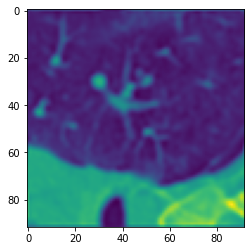

In [0]:
# Wavelet generation and feature extraction on these images
import radiomics

all_wavelet = radiomics.imageoperations.getWaveletImage(scanimg, scanmask)
for wavelet in all_wavelet:
    image = wavelet[0]
    name = wavelet[1]
    array = sitk.GetArrayFromImage(image)
    # print(array)
    plt.imshow(array[:,:,0])
    print(name, array.shape)
    result = extractor.execute(image, scanmask)
    for key, value in result.items():
        print(key, value)

# Variable selection

 ## LASSO

 See https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#cox.
 Features are extracted in using the notebook ``lasso/FeatureSelectionLasso.ipynb``.

In [0]:
input_train, output_train, input_test = load_owkin_data()
std_input_train, std_input_test = normalizing_input(input_train, input_test)
std_input_train.to_csv('MergedStdTrainingInput.csv')

In [0]:
# Variables 

lasso_features_lamb_lse = ['original_shape_Maximum3DDiameter',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glrlm_GrayLevelNonUniformity',
            'original_glrlm_RunPercentage',
            'Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'Histology_nos']

lasso_features_lamb_min = ['original_shape_Maximum3DDiameter',
        'original_shape_VoxelVolume',
        'original_firstorder_Maximum',
        'original_firstorder_Mean',
        'original_glcm_ClusterProminence',
        'original_glrlm_GrayLevelNonUniformity',
        'original_glrlm_RunPercentage',
        'Mstage',
        'Nstage',
        'SourceDataset',
        'age',
        'Histology_nos']

lasso_features_fabrice = ['Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glcm_Idm',
            'original_glcm_Idn',
            'original_glrlm_RunPercentage']       

In [0]:
input = "original_shape_Maximum3DDiameter''original_shape_VoxelVolume''original_firstorder_Maximum''original_firstorder_Mean''original_glcm_ClusterProminence''original_glrlm_GrayLevelNonUniformity''original_glrlm_RunPercentage''Mstage''Nstage''SourceDataset''age''Histology_nos"
features = input.split('\'\'')
features

## Cross correlation

# Random surivival forest

In [0]:
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate

In [0]:
def load_data(features=None):
    """ Load data for RSF usage """
    X_df, y_df, _ = load_owkin_data()
    if features != None:
        X_df = X_df[features]
    X = X_df.to_numpy()
    y = y_dataframe_to_rsf_input(y_df)
    return X_df, y_df, X, y

X_df, y_df, X, y = load_data(lasso_features_bis)
feature_name = list(X_df.columns.values)

"""
Train model
"""
params = {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
cross_validate(rsf, X, y, cv=5)

# CoxPH

In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

## Baseline

In [0]:
features_baseline = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                      'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                      'original_glcm_Idm', 'SourceDataset', 'Nstage']

In [0]:
!pip install scikit-survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

In [0]:
""" Select features """
features = lasso_features_lamb_lse

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"alpha": np.linspace(0.5, 4, 1000)
                }
grid_search = RandomizedSearchCV(CoxPHSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

## Coxnet

In [0]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

In [0]:
""" Select features """
features = high_importance_features_save

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"l1_ratio": np.linspace(0.0027, 0.0028, 1000),
                "n_alphas": range(65, 75, 1),
                }
grid_search = RandomizedSearchCV(CoxnetSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

coxph = CoxnetSurvivalAnalysis(**best_params, fit_baseline_model=True)
coxph.fit(input_train, structured_y)
y_pred = predict(coxph, input_test)
y_pred.to_csv('submission.csv')

# AutoML

In [0]:
!sudo apt-get install build-essential swig
!pip install auto-sklearn

In [0]:
import autosklearn.regression

In [0]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples   

In [0]:
random_state = 42
val_size = 0.2
n_splits = 1
time_left_for_this_task = 600 #60 #600 # default : 3600 # in seconds
per_run_time_limit = 30 #30 # default : 360 # in seconds

In [0]:
""" Choose features for Autosklearn """
feat_ = all_features

input_train, output_train, input_test = load_owkin_data()
input_train, input_test = normalizing_input(input_train, input_test)
input_train = input_train[feat_]
input_test = input_test[feat_]

In [0]:
class ShuffleSplit(BaseShuffleSplit):
    
    def __init__(self, n_splits=10, test_size=None, train_size=None,
                 random_state=None):
        n_splits = 1 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! PROBLEM : n_splits stays at 10 even when changing default value

        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state)
        self._default_test_size = 0.1

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples, self.test_size, self.train_size,
            default_test_size=self._default_test_size)

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test:(n_test + n_train)]
            yield ind_train, ind_test

In [0]:
suffle_split = ShuffleSplit(n_splits=n_splits, test_size=val_size, random_state=random_state)
ind_train, ind_val = [_tuple for _tuple in suffle_split._iter_indices(input_train, 
                                                                      y=output_train["SurvivalTime"], 
                                                                      groups=None)][0]
n_train = len(ind_train)
n_val = len(ind_val)
print("n_train", n_train)
print("n_val", n_val)

In [0]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=time_left_for_this_task, # in seconds
                                                     per_run_time_limit=per_run_time_limit,
                                                     resampling_strategy=ShuffleSplit,
                                                     resampling_strategy_arguments={'n_splits': n_splits,
                                                                                    'test_size': val_size,
                                                                                    'random_state': random_state})

In [0]:
available_models = [model_name for model_name in autosklearn.pipeline.components.regression._regressors]
print("Available models in AutoSklearnRegressor : ")
available_models

In [0]:
def my_cindex(y_true, y_pred, patient_ids, events, ind_train, ind_val, n_train, n_val, print_cindex=True):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    if len(y_true)==n_train:
        ind = ind_train
    elif len(y_true)==n_val:
        ind = ind_val
    else:
        raise Exception("y_true.shape={} but should be either {} or {}".format(y_true.shape, n_train, n_val))

    df_y_true = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_true,
                              "Event": events[ind]
                             })
    df_y_true = df_y_true.set_index("PatientID")

    df_y_pred = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_pred,
                              "Event": events[ind]*np.nan # because "`Event`column, whose value does not matter" in metrics_t9gbvr2.py
                             })
    df_y_pred = df_y_pred.set_index("PatientID")
    
    cindex_value = cindex(df_y_true, df_y_pred)
    
    if print_cindex:
        if len(y_true)==n_train:
            print("train_cindex", cindex_value)
        else:
            print("val_cindex", cindex_value)
        
    return cindex_value


cindex_scorer = autosklearn.metrics.make_scorer(name="cindex",
                                                score_func=my_cindex,
                                                optimum=1,
                                                greater_is_better=True,
                                                needs_proba=False,
                                                needs_threshold=False,
                                                patient_ids = output_train.index.values,
                                                events = output_train["Event"].values,
                                                ind_train = ind_train,
                                                ind_val = ind_val,
                                                n_train = n_train,
                                                n_val = n_val,
                                                print_cindex=False)

In [0]:
import time
start_time = time.time()
automl.fit(input_train.copy(), 
           output_train["SurvivalTime"].copy(),
           metric=cindex_scorer)
execution_time = time.time()-start_time

In [0]:
execution_time

In [0]:
print(automl.sprint_statistics())

In [0]:
start_time = time.time()
automl.refit(input_train.iloc[ind_train].copy(), output_train.iloc[ind_train]["SurvivalTime"].copy())
execution_time = time.time()-start_time
print("execution_time", execution_time)

In [0]:
print("resampling_strategy :", automl.resampling_strategy.__name__)
print(automl.sprint_statistics())

In [0]:
y_test_pred = automl.predict(input_test)
y_pred_df = pd.DataFrame(np.array([[y, np.nan] for y in y_test_pred]), index=input_test.index, columns=['SurvivalTime', 'Event'])
y_pred_df.to_csv('submission.csv')

End